In [3]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv
import matplotlib.pyplot as plt

In [4]:
%run dataset_nc.ipynb

DATASET LOADED
EnterpriseModelDatasetNC(110)


Processing...
Done!


In [5]:
torch.manual_seed(42)
dataset = dataset_nc.shuffle()

train_dataset = dataset[:int(len(dataset) * 0.75)]
test_dataset = dataset[int(len(dataset) * 0.75):]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(dataset[0])

Number of graphs total: 110
Number of training graphs: 82
Number of test graphs: 28
Data(x=[26, 1], edge_index=[2, 25], edge_attr=[25, 1], y=[26], train_mask=[26], test_mask=[26])


In [6]:
from torch_geometric.loader import DataLoader

NUM_GRAPHS_PER_BATCH = 8
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

GATGNN2(
  (conv1): GATConv(1, 64, heads=4)
  (lin1): Linear(in_features=1, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 36, heads=6)
  (lin3): Linear(in_features=256, out_features=36, bias=True)
)
Number of parameters:  200104
Epoch: 001, Loss: 16.9247, Train: 0.0000, Test: 0.0000
Epoch: 002, Loss: 9.5295, Train: 0.0000, Test: 0.0000
Epoch: 003, Loss: 2.7548, Train: 0.0000, Test: 0.0000
Epoch: 004, Loss: 2.1904, Train: 0.0000, Test: 0.0000
Epoch: 005, Loss: 1.9213, Train: 0.0000, Test: 0.0000
Epoch: 006, Loss: 1.4239, Train: 0.0000, Test: 0.0000
Epoch: 007, Loss: 1.3623, Train: 0.0000, Test: 0.0000
Epoch: 008, Loss: 1.3673, Train: 0.0000, Test: 0.0000
Epoch: 009, Loss: 1.2795, Train: 0.0000, Test: 0.0000
Epoch: 010, Loss: 1.1364, Train: 0.0000, Test: 0.0000
Epoch: 011, Loss: 1.0210, Train: 0.0000, Test: 0.0000
Epoch: 012, Loss: 1.0380, Train: 0.0000, Test: 0.0000
Epoch: 013, Los

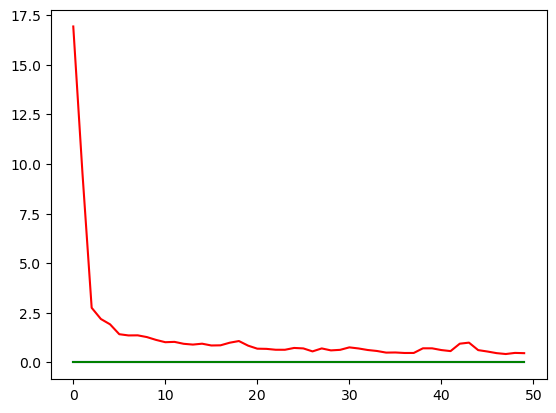

Max Accuracy: 0.0000


In [8]:
max_acc = 0
class GATGNN2(torch.nn.Module): # uses edge_attr
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes)

        
    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN2().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index, data.edge_attr), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def flatten(l):
    return [item for sublist in l for item in sublist]


@torch.no_grad()
def test2(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append([int(y.argmax()) for y in data.y])
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append([int(pred.argmax()) for pred in out])

    preds = flatten(preds)
    ys = flatten(ys)
    correct = 0
    
    for y, pred in zip(ys, preds):
        if(y == pred):
            correct += 1
    
    return correct / len(ys)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


loss_values = []
train_acc_values = []
acc_values = []

for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if(test_acc > max_acc):
        max_acc = test_acc
    
    loss_values.append(loss)
    acc_values.append(test_acc)
    train_acc_values.append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Train: {train_acc:.4f}, 'f'Test: {test_acc:.4f}')
    
    if(test_acc >= 0.95):
        break

plt.plot(loss_values, 'r', acc_values, 'b', train_acc_values, 'g')
plt.show()
print(f'Max Accuracy: {max_acc:.4f}')

In [56]:
torch.save(model, '../models/model_nc.pth')

In [57]:
loaded_model = torch.load('../models/model_nc.pth')
loaded_model.eval()
test_acc = test(test_loader)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9542
